Evaluation: Started
Analyzing file: MPB-73E


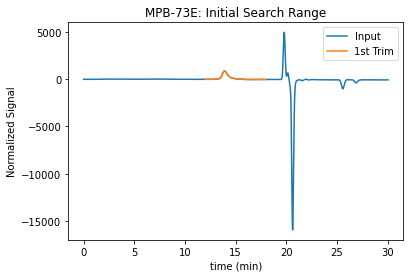

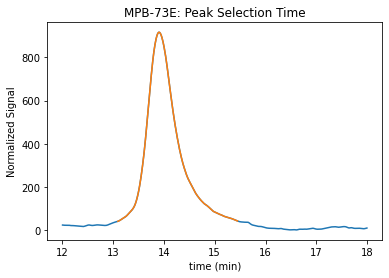

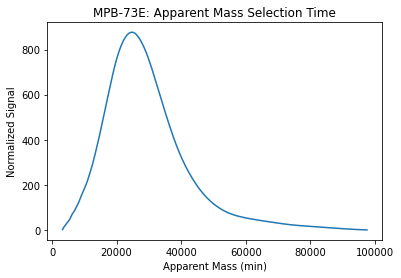

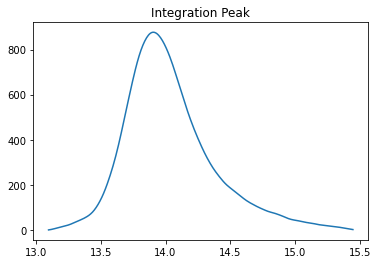

Analyzing file: MPB-73A


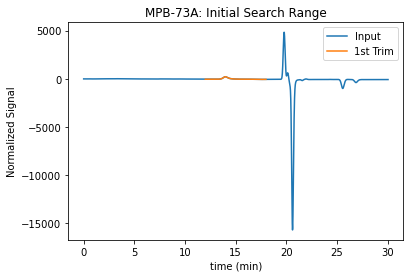

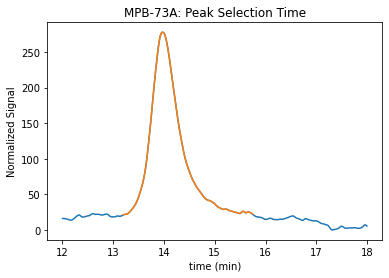

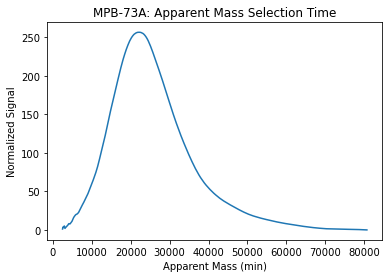

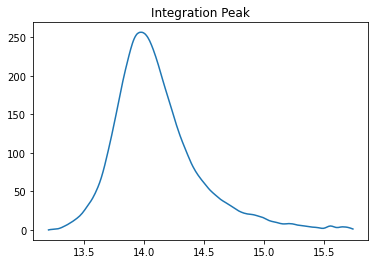

Analyzing file: MPB-73B


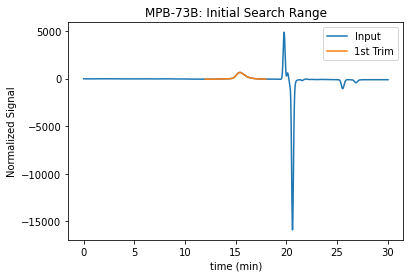

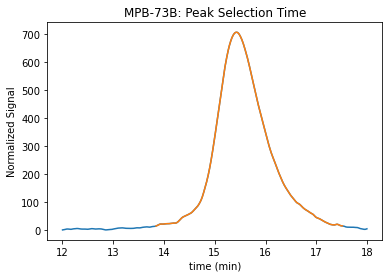

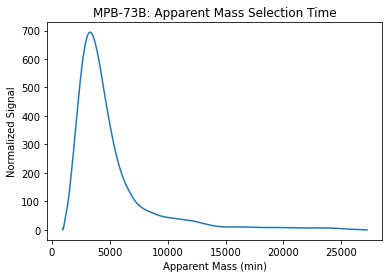

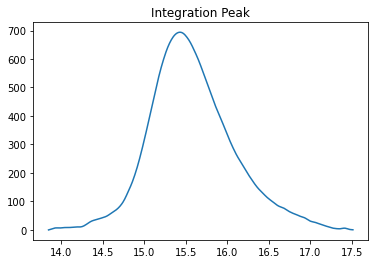

Analyzing file: MPB-71A


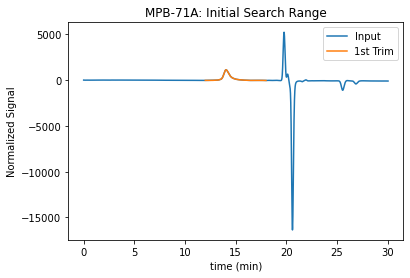

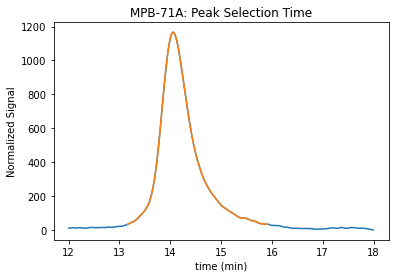

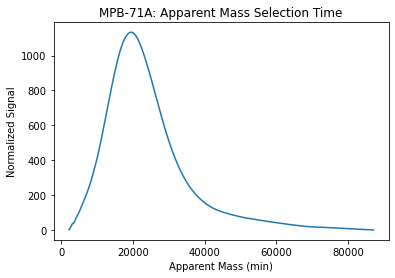

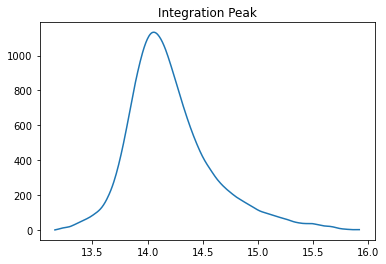

Analyzing file: MPB-71B


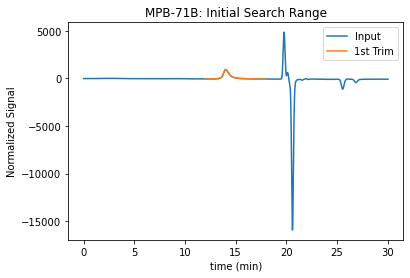

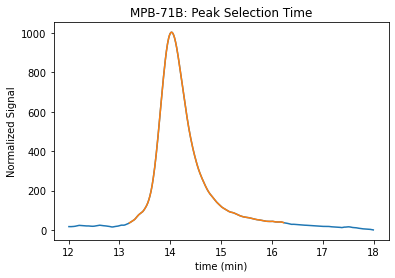

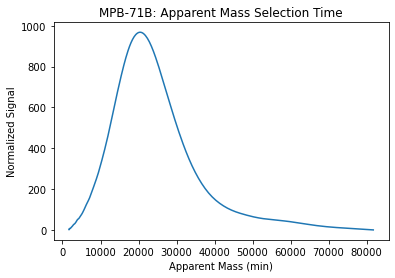

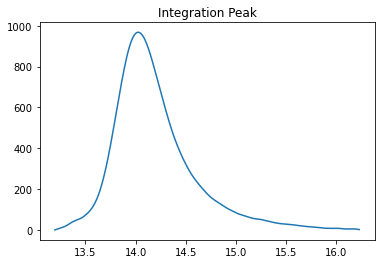

Analyzing file: MPB-62C


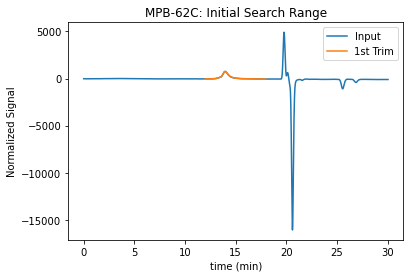

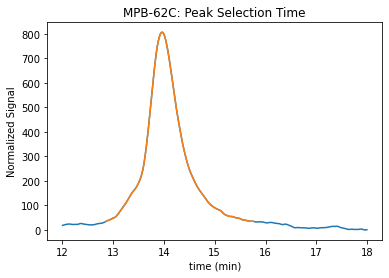

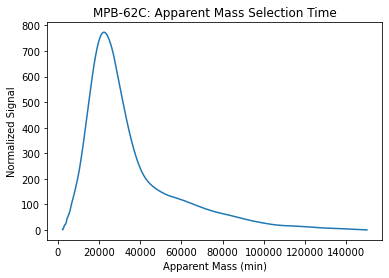

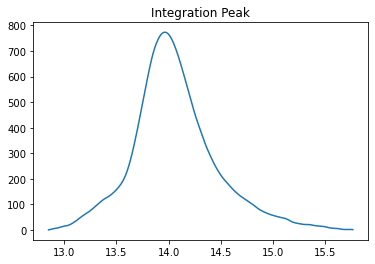

      name      start        end            Mw            Mn        Pd  \
0  MPB-73E  13.095805  15.455215  28700.364326  23245.239293  1.234677   
1  MPB-73A  13.204035  15.751043  25219.573641  20730.665509  1.216535   
2  MPB-73B  13.846198  17.518796   4505.289928   3370.854732  1.336542   
3  MPB-71A  13.160743  15.924210  23254.112466  18220.694069  1.276247   
4  MPB-71B  13.196820  16.234469  23883.275876  18849.681161  1.267039   
5  MPB-62C  12.850484  15.772689  34222.668388  23822.750853  1.436554   

             Mp   Peak Area  Peak Height  
0  24786.769258  596.797576   876.769990  
1  22088.724134  170.028625   256.650002  
2   3291.420126  761.471156   693.940010  
3  19494.261000  828.268517  1133.829941  
4  20395.790593  700.595667   968.599991  
5  22600.963725  596.913673   773.300014  
File created


In [1]:

import numpy as np
import pandas as pd
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.sparse import linalg
import numpy as np
from numpy.linalg import norm
from scipy.signal import find_peaks, peak_prominences, peak_widths
from scipy.integrate import simps, quad, romb
from pathlib import Path
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt 


#Edit File Path/Save Path and Folder variables as required

lowrange = 1000
highrange = 90000

timestart = 12
timeend = 18
def main():
    print("Evaluation: Started")

    #Specify the folder (unzipped) of GPC txt files
    folder = r"C:\Users\jeshu\Downloads\MPB-01-62-73\MPB-01-62-73"
    
    
    method = simplesum #discreteintegrator uses moment formula/ Simplesum uses the sum method to calculate pd, mw, and mn 
                                #Use Simplesum for worse case scenerio numbers and discreteintegator for best case
    
    baselinesubtract = False #Avoid True? (uses baseline subtract from paper --> Needs more testing and optimization)
    mass_search = False #Uses either the times (False) you specified or mass range you specified (True) 
    G = GPC(folder, method,baselinesubtract, mass_search)

    


def GPC(folder, method,baselinesubtract, mass_search):
    files = Path(folder).glob('**/*.txt')

    df = pd.DataFrame()
    data1 = []
    info = []
    time = []


    for filepathGPC in files:
        with open(filepathGPC, 'r') as f:
            data = []
            for itrs, line in enumerate(f):
                if line.find('Sample Name') != -1:
                    name = line.split( )[3]
                    print(f"Analyzing file: {name}")
                if len(line.split( )) > 0:
                    if is_number(line.split( )[0]):
                        data.append([float(x) for x in line.split( )])
            GPCdata = np.transpose(np.array(data))

            apparentmass = 10**(GPCcalnew(GPCdata[0]))

            l = []
            timeset = []
            if mass_search:
                for i in range(0, len(apparentmass)):
                    if apparentmass[i] > lowrange and apparentmass[i] < highrange:
                        if apparentmass[i] > apparentmass[i+1]:
                            l.append([apparentmass[i],GPCdata[1,i]])    
                            timeset.append([GPCdata[0,i]/60, GPCdata[1,i]])
            else:
                for i in range(0, len(apparentmass)):               
                    if GPCdata[0,i] > timestart*60 and GPCdata[0,i] < timeend*60:
                        l.append([apparentmass[i],GPCdata[1,i]])    
                        timeset.append([GPCdata[0,i]/60, GPCdata[1,i]])                       
        

        timeset = np.transpose(np.array(timeset))
        l = np.transpose(np.array(l))


        prenorm =np.array(timeset)

        plt.title(name + ": Initial Search Range")
        plt.xlabel("time (min)")
        plt.ylabel('Normalized Signal')
        plt.plot(GPCdata[0]/60, GPCdata[1], label = 'Input')
        plt.plot(timeset[0], timeset[1], label = '1st Trim')
        plt.legend()
        plt.show()


        trim, left_ips, right_ips = peakfinder(0.3, prenorm)
        if type(trim) != type(False):
            if baselinesubtract: 
                trim[1] = baseline_als(trim[1]-trim[1][0],1000, 0.1) 
            else:
                trim[1] = trim[1]-min(trim[1])
                prenorm[1] = prenorm[1] - min(prenorm[1])
            Mn, Mw, Pd = method([l[0, left_ips:right_ips],trim[1]])

            plt.title(name + ": Peak Selection Time")
            plt.xlabel("time (min)")
            plt.ylabel('Normalized Signal')
            diff = max(prenorm[1]) - max(trim[1])
            plt.plot(prenorm[0], prenorm[1])

            plt.plot(trim[0], trim[1] + diff)

            plt.show()
            plt.title(name + ": Apparent Mass Selection Time")
            plt.xlabel("Apparent Mass (min)")
            plt.ylabel('Normalized Signal')
            
            plt.plot(l[0, left_ips:right_ips],trim[1])
            plt.show()

            pa = peakarea(name, trim)

            info.append([name,timeset[0][left_ips], timeset[0][right_ips], Mw, Mn, Pd, l[0][list(l[1]).index(max(l[1]))], pa, max(trim[1])])
            
            

        else:
            plt.title(name + ": Peak Selection ")
            plt.xlabel("Apparent Mass (kDa)")
            plt.ylabel('Normalized Signal')
            plt.plot(timeset[0], timeset[1], label = '1st Trim')
            plt.legend()
            plt.show()
            print(f"{name}: PEAK not found")
            trim = []
    
            info.append([name, ' ', ' ', ' ', ' ', ' ',' '])

    



        
        data1.append(trim)    
        time.append(timeset)
    
    df = pd.DataFrame(info, columns = ['name', 'start', 'end', 'Mw', 'Mn', 'Pd', 'Mp', 'Peak Area', 'Peak Height'])
    print(df)

    Save(df,time,  data1, df['name'].to_numpy())


def peakfinder(prom, prenorm):
    postnorm = np.array([prenorm[0], (prenorm[1] - prenorm[1][0])/max(prenorm[1] - prenorm[1][0]) ])

    peaks2, _ = find_peaks(postnorm[1], prominence=prom)   
    if len(peaks2) != 0:

        prominences, left_bases, right_bases = peak_prominences(postnorm[1], peaks2)
        offset = np.ones_like(prominences)
        widths, h_eval, left_ips, right_ips = peak_widths(
            postnorm[1], peaks2, 
            rel_height=0.98,
            prominence_data=(offset, left_bases, right_bases)
        )
        left_ips, right_ips = int(left_ips), int(right_ips)
        trim = np.array([prenorm[0][left_ips:right_ips], prenorm[1][left_ips:right_ips]])
        return trim,  int(left_ips), int(right_ips) 
    else:
        return False, False, False

def GPCcalnew(t):
    #specify calibration curve data path (has to be .csv)
    filepath = r"Cali.csv"
    df = pd.read_csv(filepath, error_bad_lines=False).to_numpy()
    df = np.transpose(df)
    z = np.polyfit(df[0], df[1], 4)
    p = np.poly1d(z)
    return p(t/60)


    


def simplesum(trim):
    N = 0
    Mnnum = 0
    Mwnum = 0

    for i in range(0, len(trim[0])):
        N += trim[1][i]
        Mnnum += trim[1][i]*trim[0][i]
        Mwnum += trim[1][i]*trim[0][i]**2
    Mw = Mwnum/Mnnum
    Mn = Mnnum/N
    Pd = Mw/Mn
    return Mn, Mw, Pd
    
def discreteintegrator(data):
    integrator = simps
    Mn = integrator(data[0]*data[1], data[0])/integrator(data[1], data[0])
    Mw = integrator(data[1]*data[0]**2, data[0])/integrator(data[1]*data[0], data[0])
    Pd = Mw/Mn
    return Mn, Mw, Pd
def peakarea(name, data):
    plt.title('Integration Peak')
    plt.plot(data[0], data[1])
    plt.show()
    integrator = simps
    return integrator(data[1], data[0])


def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

    
def Save(df,time, data, name):
    try:
        #You can change the file name of the excel file written if you want
        writer = pd.ExcelWriter('workedupdata.xlsx', engine='xlsxwriter')

        workbook = writer.book
        row = 0 
        df.to_excel(writer, sheet_name='Summary')

        for sheet, info  in enumerate(data):
            worksheet = workbook.add_worksheet(name[sheet])
            for col, data in enumerate(info):
                worksheet.write_column(row, col, data)
                worksheet.write_column(row, col+3, time[sheet][col])
             
        workbook.close()
        print("File created")
    except:
        print("Failed: Close File to update/Lack of Perm")
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

main()




